## Modeling: Small business loans

I will now build a model to classify small business loans according to whether they will be paid off or default. This is a classification problem, and many of the variables have skewed distributions. Decision tree algorithms often perform well in such cases. I will try two decision-tree based algorithms: random forest, and gradient boosting. I will also tune hyperparameters for both algorithms.

### Loading the data

In [1]:
## Import needed Python module and functions 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
## Import features for training values
features = pd.read_csv('../Data/Processed/X_train.csv')

In [3]:
## Import labels for training data
labels = pd.read_csv('../Data/Processed/y_train.csv')

In [4]:
## Convert training data into numpy arrays to train models
feature_names = features.columns
X = features.values
y = labels.values
y = y.ravel()

### Random forest model

#### Baseline model

To get a benchmark for hyperparameter tuning, let's first see how the Random Forest algorithm performs just using the `sklearn` defaults.

In [5]:
rf_model = RandomForestClassifier(random_state=42)

In [6]:
cv_results_rf = cross_validate(rf_model, X, y, scoring=('f1', 'accuracy'), cv=3, n_jobs=1)

In [7]:
## Print out cross-validated metrics for the 'out of the box' model.
pd.DataFrame(cv_results_rf).mean()

fit_time         95.019973
score_time        7.766445
test_f1           0.779608
test_accuracy     0.929147
dtype: float64

#### Hyperparameter tuning

Now, let's see if I can do better with hyperparameter tuning. Since the data is unbalanced, I will use f1 score as the metric to optimize, rather than accuracy. While there are many hyperparameters I could tune, I will focus on `n_estimators`, `criterion` and `max_depth.`

In [8]:
## Set up grid with possible combinations of hyperparameters to search
params = {'n_estimators': [50, 100, 200],
          'criterion' : ['gini', 'entropy'],
          'max_depth': [50, 100, 200, None]
}

rf_for_search = RandomForestClassifier(random_state=42)

In [9]:
## Execute grid search to find the best hyperparameters
search_results_rf = GridSearchCV(estimator=rf_for_search, param_grid=params, 
                                 cv=3, scoring=('accuracy', 'f1'), 
                                 refit='f1', n_jobs=1, verbose=5)
search_results_rf.fit(X, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=50, n_estimators=50; accuracy: (test=0.929) f1: (test=0.779) total time=  49.4s
[CV 2/3] END criterion=gini, max_depth=50, n_estimators=50; accuracy: (test=0.929) f1: (test=0.778) total time=  51.9s
[CV 3/3] END criterion=gini, max_depth=50, n_estimators=50; accuracy: (test=0.928) f1: (test=0.776) total time=  52.9s
[CV 1/3] END criterion=gini, max_depth=50, n_estimators=100; accuracy: (test=0.929) f1: (test=0.780) total time= 1.7min
[CV 2/3] END criterion=gini, max_depth=50, n_estimators=100; accuracy: (test=0.929) f1: (test=0.780) total time= 1.7min
[CV 3/3] END criterion=gini, max_depth=50, n_estimators=100; accuracy: (test=0.929) f1: (test=0.779) total time= 1.7min
[CV 1/3] END criterion=gini, max_depth=50, n_estimators=200; accuracy: (test=0.930) f1: (test=0.781) total time= 3.4min
[CV 2/3] END criterion=gini, max_depth=50, n_estimators=200; accuracy: (test=0.930) f1: (test=0.782) t

[CV 2/3] END criterion=entropy, max_depth=None, n_estimators=100; accuracy: (test=0.929) f1: (test=0.782) total time= 1.8min
[CV 3/3] END criterion=entropy, max_depth=None, n_estimators=100; accuracy: (test=0.929) f1: (test=0.779) total time= 1.8min
[CV 1/3] END criterion=entropy, max_depth=None, n_estimators=200; accuracy: (test=0.930) f1: (test=0.782) total time= 3.6min
[CV 2/3] END criterion=entropy, max_depth=None, n_estimators=200; accuracy: (test=0.930) f1: (test=0.784) total time= 3.6min
[CV 3/3] END criterion=entropy, max_depth=None, n_estimators=200; accuracy: (test=0.929) f1: (test=0.780) total time= 3.6min


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [50, 100, 200, None],
                         'n_estimators': [50, 100, 200]},
             refit='f1', scoring=('accuracy', 'f1'), verbose=5)

In [10]:
scores_rf = pd.DataFrame(search_results_rf.cv_results_)[['param_criterion', 
                                                         'param_n_estimators', 
                                                         'param_max_depth', 
                                                         'mean_test_accuracy', 
                                                         'mean_test_f1', 
                                                         'mean_fit_time']]
scores_rf.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_criterion,param_n_estimators,param_max_depth,mean_test_accuracy,mean_test_f1,mean_fit_time
14,entropy,200,50,0.929659,0.782551,198.826593
23,entropy,200,None,0.929508,0.781982,199.930429
20,entropy,200,200,0.929508,0.781982,198.362246
17,entropy,200,100,0.929508,0.781982,198.268588
2,gini,200,50,0.929575,0.781366,189.486307


In [11]:
## Print out the best hyperparameters found
search_results_rf.best_params_

{'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}

In [12]:
best_rf = search_results_rf.best_estimator_

Now that I have chosen the best hyperparameters for the random forest model, I fit the model on the entire training set, and evaluate performance on the validation data.

In [13]:
%%time
## Fit our optimized random forest model to the training data
best_rf.fit(X, y)

CPU times: user 5min 46s, sys: 1.88 s, total: 5min 48s
Wall time: 5min 48s


RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=200,
                       random_state=42)

In [14]:
X_val_df = pd.read_csv('../Data/Processed/X_test.csv')
y_val_df = pd.read_csv('../Data/Processed/y_test.csv')

In [15]:
## Load the validation data, and save features as an array and labels as a 
X_val = X_val_df.values
y_val = y_val_df.values
y_val = y_val.ravel()

In [16]:
%%time
## Use our model to make a prediction on the validation set
y_val_pred_rf = best_rf.predict(X_val)

CPU times: user 22.3 s, sys: 140 ms, total: 22.5 s
Wall time: 22.5 s


In [17]:
## Print metrics for this model.
print("Accuracy: {:.2f}".format(accuracy_score(y_val_pred_rf, y_val)))
print("Precision: {:.2f}".format(precision_score(y_val_pred_rf, y_val)))
print("Recall: {:.2f}".format(recall_score(y_val_pred_rf, y_val)))
print("f1 score: {:.2f}".format(f1_score(y_val_pred_rf, y_val)))

Accuracy: 0.93
Precision: 0.73
Recall: 0.85
f1 score: 0.79


Finally, let's examine the most important features of our model.

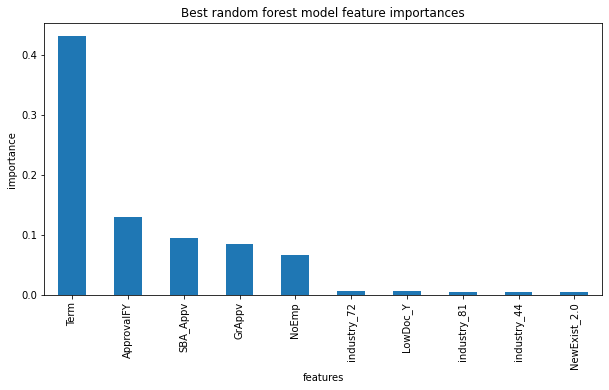

In [18]:
## Graph shows feature importances for this model
plt.subplots(figsize=(10, 5))
importances = best_rf.feature_importances_
labeled_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
labeled_importances.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest model feature importances');

#### Conclusion: random forest

Random forest offers decent performance even with the default hyperparameters from `sklearn`. However, my efforts to improve performance with hyperparameter turning were not very successful. The optimized model performed only about one percentage point better on the target metric, but took more than three times longer to train. It's possible that the algorithm would do better with an even larger value of `n_estimators`, but this would mean longer training times. For now, I will try a different algorithm. 

### Gradient Boosting Algorithm

#### Evaluating the default model

I will now follow a similar process with gradient boosting. To being, I will evaluate the default version of the model.

In [19]:
gb_model = GradientBoostingClassifier(random_state=42)

In [20]:
cv_results_gb = cross_validate(gb_model, X, y, scoring=('f1', 'accuracy'), cv=3, n_jobs=1)

In [21]:
# Print cross-validated metrics for the 'out of the box' gradient boosting model
pd.DataFrame(cv_results_gb).mean()

fit_time         263.997793
score_time         0.711314
test_f1            0.786835
test_accuracy      0.929814
dtype: float64

It seems that gradient boosting gives similar performance to random forest with the default setting. Lets see if gradient boosting is more responsive to hyperparameter tuning.

#### Hyperparameter tuning

One again I conduct a grid search. This time instead of `criterion`, I vary the parameter `learning_rate`, which determines how quickly the boosting algorithm learns from its mistakes at each iteration. Gradient boosting tends to perform well with a large number of relatively shallow trees, so I will try small values for `max_depth`.

In [22]:
# Set up parameter grid and declare a new estimator
params_gb = {'n_estimators': [100, 200],
            'max_depth': [7, 11, 15],
            'learning_rate': [0.01, 0.1, 1]}

gb_for_search = GradientBoostingClassifier(random_state=42)

In [23]:
# Execute the grid search
search_results_gb = GridSearchCV(estimator=gb_for_search, param_grid=params_gb, cv=3, 
                                 scoring=('accuracy', 'f1'), refit='f1', 
                                 n_jobs=1, verbose=5)
search_results_gb.fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=100; accuracy: (test=0.928) f1: (test=0.764) total time= 8.2min
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=100; accuracy: (test=0.927) f1: (test=0.758) total time= 8.2min
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=100; accuracy: (test=0.928) f1: (test=0.766) total time= 8.2min
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=200; accuracy: (test=0.937) f1: (test=0.809) total time=16.5min
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=200; accuracy: (test=0.937) f1: (test=0.806) total time=16.4min
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=200; accuracy: (test=0.937) f1: (test=0.807) total time=16.4min
[CV 1/3] END learning_rate=0.01, max_depth=11, n_estimators=100; accuracy: (test=0.937) f1: (test=0.803) total time=12.2min
[CV 2/3] END learning_rate=0.01, max_depth=11, n_estimators=100; accuracy: (t

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [7, 11, 15], 'n_estimators': [100, 200]},
             refit='f1', scoring=('accuracy', 'f1'), verbose=5)

In [24]:
## Print out metrics for the top 5 models
scores_gb = pd.DataFrame(search_results_gb.cv_results_)[['param_learning_rate', 
                                                         'param_max_depth', 
                                                         'param_n_estimators', 
                                                         'mean_test_accuracy', 
                                                         'mean_test_f1', 
                                                         'mean_fit_time']]
scores_gb.sort_values(by='mean_test_f1', ascending=False).head(5)

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_accuracy,mean_test_f1,mean_fit_time
9,0.1,11,200,0.947015,0.846181,1536.436442
8,0.1,11,100,0.946742,0.845048,749.514324
7,0.1,7,200,0.946075,0.841763,1008.331143
11,0.1,15,200,0.945130,0.840616,2131.787125
10,0.1,15,100,0.944729,0.839703,1057.613049


Here I noticed something interesting. The second-best model performs almost as well as the best model--both accuracy and precision agree to the second decimal place--but requires only about half the training time. Since gradient boosting models generally need much more training time than random forest, this is an important consideration. Using a model that is easier to train means I could more easily improve the model by training on more recent data if it became available. So, I will select the *second* model in the table above as the optimized gradient boosting classifier.

I now train a model with the chosen hyperparameters from the search, and evaluate its performance on the test set. 

In [25]:
## Choose the estimator with the best f1 score
best_gb = GradientBoostingClassifier(n_estimators=100, 
                                     learning_rate=0.1, max_depth=11, random_state=42)

In [26]:
%%time
## Fit the optimized gradient boosting model to all of the training data
best_gb.fit(X, y)

CPU times: user 14min 2s, sys: 59.1 ms, total: 14min 2s
Wall time: 14min 2s


GradientBoostingClassifier(max_depth=11, random_state=42)

In [27]:
%%time
## Now, use the optimized gradient boosting model to make predictions for the test set
y_val_pred_gb = best_gb.predict(X_val)

CPU times: user 2.01 s, sys: 7.99 ms, total: 2.01 s
Wall time: 2.01 s


In [28]:
## Print evaluation metrics for this model.
print("Accuracy: {:.2f}".format(accuracy_score(y_val_pred_gb, y_val)))
print("Precision: {:.2f}".format(precision_score(y_val_pred_gb, y_val)))
print("Recall: {:.2f}".format(recall_score(y_val_pred_gb, y_val)))
print("f1 score: {:.2f}".format(f1_score(y_val_pred_gb, y_val)))

Accuracy: 0.95
Precision: 0.83
Recall: 0.86
f1 score: 0.85


Finally, I plot feature importances for the gradient boosting model.

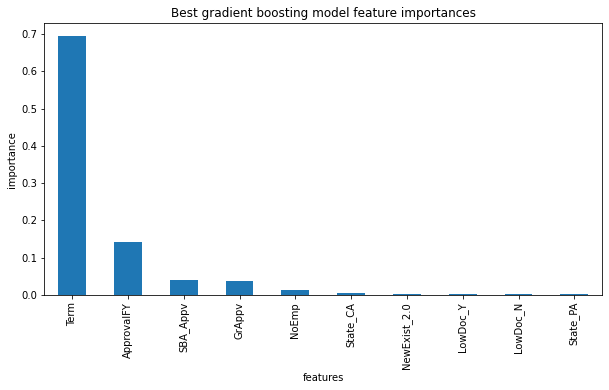

In [29]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 5))
importances = best_gb.feature_importances_
labeled_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
labeled_importances.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting model feature importances');

#### Conclusion: gradient boosting

The gradient boosting model performed similarly to random forest without hyperparameter turning. After tuning hyperparameters, I found that gradient boosting was significantly more powerful. I was able to acheive an f1 score of 0.85, a full 6 percentage-points higher than my best random forest model. The main downside was a noticeably longer training time.

### Choosing the best model

The best model is gradient boosting, with the `max_depth` parameter set to 11. (All other parameter values are defaults). This model outperformed my best random forest model on four metrics: accuracy, precision, recall, and f1-score. The most notable difference was in precision, which was 0.83 for gradient boosting verus 0.73 for random forest. Hence the gradient boosting model had fewer false positives; it is much less likely to falsely predict that a loan would go into default. 

The major disadvantage of gradient boosting is a longer fit time. My best gradient boosting model had a mean fit time of 750 seconds when doing three-fold cross-validation on the training data. For random forest, the mean fit time was about 200 seconds. While this is a noticable difference, the training time for gradient boosting is not prohibitive. In addition, the gradient boosting model had much faster prediction times (approximately 2 seconds to predict the test set, compared to 22 seconds for random forest). With its faster, more precise predictions, gradient boosting is worth the extra training time.

As a final remark, it is reassuring to note that random forest and gradient boosting had the same top-five features, although gradient boosting put even more emphasis on the `term` feature than random forest. The fact that the models agreed on which features are import suggests that both are finding genuine relationships in the data.